In [57]:
%pip install opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [58]:
!pip install ultralytics

In [100]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.cElementTree as ET
import glob
import os
import json
import random
import shutil
import cv2
from PIL import Image, ImageOps
import glob
import xml.etree.ElementTree as et
import seaborn as sns
import zipfile

# load the facemask dataset**

In [126]:
!pwd

/Users/raneem/Desktop/SDA PROJECTS/ironhack-/facemask_usecase


In [ ]:
# run the code below onlly once!

'''zip_file_path = 'face-mask-detection.zip'

# Unzip the file in the current directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')

print("Unzipping completed.") '''

# 1. Preprocess the data

In [101]:
annotations_dir = '/Users/raneem/Desktop/SDA PROJECTS/ironhack-/facemask_usecase/annotations'
annotation_files = os.listdir(annotations_dir)

# Read the first annotation file
first_annotation_file = os.path.join(annotations_dir, annotation_files[0])
with open(first_annotation_file, 'r') as f:
    contents = f.read()
    print(contents)


<annotation>
    <folder>images</folder>
    <filename>maksssksksss299.png</filename>
    <size>
        <width>301</width>
        <height>400</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>62</xmin>
            <ymin>194</ymin>
            <xmax>160</xmax>
            <ymax>320</ymax>
        </bndbox>
    </object>
</annotation>


In [102]:
images_dir = '/Users/raneem/Desktop/SDA PROJECTS/ironhack-/facemask_usecase/images'
image_files = os.listdir(images_dir)

# Read the first image file
first_image_file = os.path.join(images_dir, image_files[0])
first_image = Image.open(first_image_file)
first_image.show()

**content of annotations and images folder**:

annotations cntains metadata about the images stored in the images folder. This metadata can include information such as labels, bounding boxes, segmentation masks, or any other relevant data that describes the content of the images.

The images folder contains the actual image files that are being annotated.

In [103]:
# Define the path to the XML files
xml_files = glob.glob('/Users/raneem/Desktop/SDA PROJECTS/ironhack-/facemask_usecase/annotations/*.xml')

# Initialize a dictionary to store object information
object_info = {
    'filename': [],
    'width': [],
    'height': [],
    'xmin': [],
    'xmax': [],
    'ymin': [],
    'ymax': [],
    'name': []
}

# Iterate over each XML file
for path in xml_files:
    # Parse the XML file
    tree = et.parse(path)
    root = tree.getroot()
    
    # Extract filename
    fname = root.find('filename').text
    
    # Extract image size
    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    
    # Extract object information
    for obj in root.findall('object'):
        bbox_info = obj.find('bndbox')
        name = obj.find('name').text
        xmin = bbox_info.find('xmin').text
        xmax = bbox_info.find('xmax').text
        ymin = bbox_info.find('ymin').text
        ymax = bbox_info.find('ymax').text
        
        # Append extracted information to the dictionary
        object_info['filename'].append(fname)
        object_info['width'].append(width)
        object_info['height'].append(height)
        object_info['xmin'].append(xmin)
        object_info['xmax'].append(xmax)
        object_info['ymin'].append(ymin)
        object_info['ymax'].append(ymax)
        object_info['name'].append(name)

In [104]:
# Convert the object_info dictionary to a DataFrame
df_annotations = pd.DataFrame(object_info)

# Columns to be converted to float
columns_to_convert = ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']
df_annotations[columns_to_convert] = df_annotations[columns_to_convert].astype('float32')

# Save the DataFrame to a CSV file
df_annotations.to_csv('labels.csv', index=False)

In [105]:
# Display the first rows in the DataFrame
df_annotations.head()

,filename,width,height,xmin,xmax,ymin,ymax,name
0,maksssksksss299.png,301.0,400.0,62.0,160.0,194.0,320.0,without_mask
1,maksssksksss528.png,301.0,400.0,43.0,149.0,169.0,308.0,without_mask
2,maksssksksss272.png,275.0,400.0,48.0,218.0,107.0,304.0,mask_weared_incorrect
3,maksssksksss514.png,400.0,267.0,28.0,43.0,78.0,99.0,with_mask
4,maksssksksss514.png,400.0,267.0,160.0,176.0,66.0,83.0,with_mask


do we need to resize the images to a specific size? if yes, what is the size?

In [106]:
df_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  4072 non-null   object 
 1   width     4072 non-null   float32
 2   height    4072 non-null   float32
 3   xmin      4072 non-null   float32
 4   xmax      4072 non-null   float32
 5   ymin      4072 non-null   float32
 6   ymax      4072 non-null   float32
 7   name      4072 non-null   object 
dtypes: float32(6), object(2)
memory usage: 159.2+ KB


Visualize the distribution of each class (mask, no mask, mask incorrect)

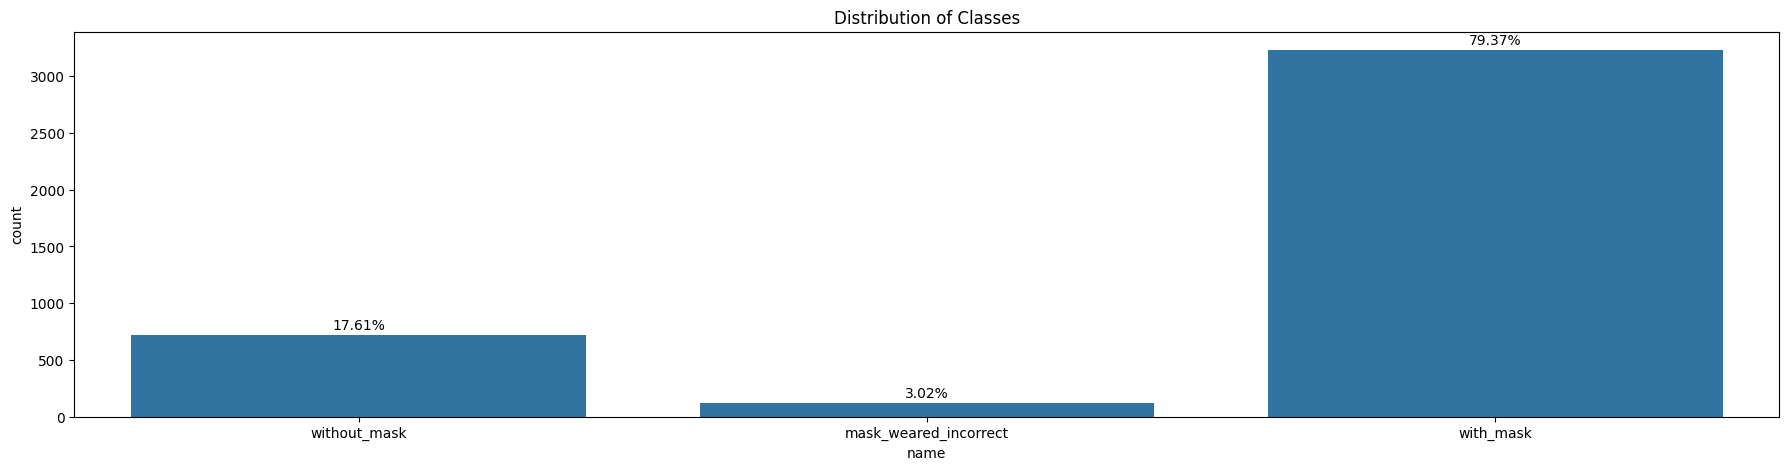

In [107]:
# Visualize the distribution
plt.figure(figsize=(22, 5))
sns.countplot(x='name', data=df_annotations)
plt.title('Distribution of Classes')
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x()+p.get_width()/2., height + 50, '{:1.2f}%'.format(100*height/len(df_annotations)), ha="center")
plt.show()

In [108]:
mask_clases = df_annotations['name'].value_counts()
mask_clases

name
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

## Visualize some images and its annotations

## first image

In [109]:
# Display image
first_image_file = os.path.join(images_dir, image_files[0])
second_image = Image.open(first_image_file)
second_image.show()

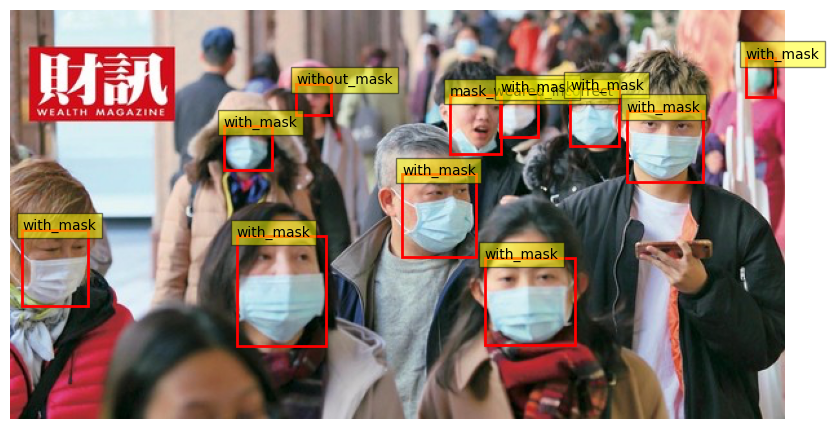

In [110]:
def plot_bounding_boxes(image_path, annotations):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    for _, row in annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin, row['name'], bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Filter annotations for the image
first_image_annotations = df_annotations[df_annotations['filename'] == os.path.basename(first_image_file)]

# Plot bounding boxes on the image
plot_bounding_boxes(first_image_file, first_image_annotations)

## second image

In [111]:
# Display image
second_image_file = os.path.join(images_dir, image_files[1])
second_image = Image.open(second_image_file)
second_image.show()

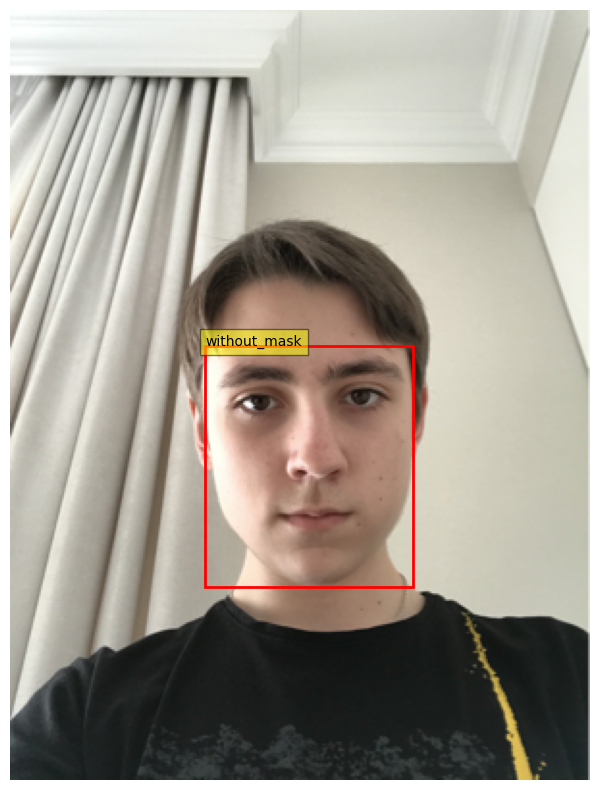

In [112]:
def plot_bounding_boxes(image_path, annotations):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    for _, row in annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin, row['name'], bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Filter annotations for the image
second_image_annotations = df_annotations[df_annotations['filename'] == os.path.basename(second_image_file)]

# Plot bounding boxes on the image
plot_bounding_boxes(second_image_file, second_image_annotations)

## Conver the catagorical values

In [113]:
print(df_annotations['name'].unique()) 

['without_mask' 'mask_weared_incorrect' 'with_mask']


In [114]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the 'name' column and transform it to numerical values
df_annotations['id'] = label_encoder.fit_transform(df_annotations['name'])

Now df_annotations has a new column 'id' with numerical codes for each category

In [115]:
df_annotations.head()

,filename,width,height,xmin,xmax,ymin,ymax,name,id
0,maksssksksss299.png,301.0,400.0,62.0,160.0,194.0,320.0,without_mask,2
1,maksssksksss528.png,301.0,400.0,43.0,149.0,169.0,308.0,without_mask,2
2,maksssksksss272.png,275.0,400.0,48.0,218.0,107.0,304.0,mask_weared_incorrect,0
3,maksssksksss514.png,400.0,267.0,28.0,43.0,78.0,99.0,with_mask,1
4,maksssksksss514.png,400.0,267.0,160.0,176.0,66.0,83.0,with_mask,1


## Convert to yolo format(normliaze the bounding box coordinates)

converting the bounding box coordinates from absolute pixel values to normalized values

In [116]:
# Calculate the normalized x-coordinate of the center of each bounding box
df_annotations['center_x'] = (df_annotations['xmax'] + df_annotations['xmin']) / (2 * df_annotations['width'])

# Calculate the normalized y-coordinate of the center of each bounding box
df_annotations['center_y'] = (df_annotations['ymax'] + df_annotations['ymin']) / (2 * df_annotations['height'])

# Calculate the normalized width of each bounding box
df_annotations['W'] = (df_annotations['xmax'] - df_annotations['xmin']) / df_annotations['width']

# Calculate the normalized height of each bounding box
df_annotations['H'] = (df_annotations['ymax'] - df_annotations['ymin']) / df_annotations['height']

In [117]:
file_df = pd.DataFrame(df_annotations['filename'].unique(),columns=['filename'])

In [118]:
file_df.head()

,filename
0,maksssksksss299.png
1,maksssksksss528.png
2,maksssksksss272.png
3,maksssksksss514.png
4,maksssksksss500.png


## Split the data into train and test and validation sets

In [119]:
# Shuffle the DataFrame
file_df = file_df.sample(frac=1).reset_index(drop=True)

# Define the split ratios
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

# Calculate the number of samples for each set
train_size = int(len(file_df) * train_frac)
val_size = int(len(file_df) * val_frac)

# Split the DataFrame
train_df = file_df[:train_size]
val_df = file_df[train_size:train_size + val_size]
test_df = file_df[train_size + val_size:]

# Convert the 'filename' columns to tuples
train_filenames = tuple(train_df['filename'])
val_filenames = tuple(val_df['filename'])
test_filenames = tuple(test_df['filename'])

In [120]:
# Print out the sizes of each set
print(f"ALL FILES: {len(file_df)}")
print(f"Training set size: {len(train_filenames)}")
print(f"Testing set size: {len(test_filenames)}")
print(f"Validation set size: {len(val_filenames)}")

ALL FILES: 853
Training set size: 597
Testing set size: 129
Validation set size: 127


In [121]:
# Filter the original DataFrame to get labels for training, validation, and testing sets
train_label = df_annotations.query(f"filename in {train_filenames}")
test_label = df_annotations.query(f"filename in {test_filenames}")
val_label = df_annotations.query(f"filename in {val_filenames}")

In [125]:
# Print the number of rows and columns in each set
print(f"Training set: {train_label.shape}")
print(f"Validation set: {val_label.shape}")
print(f"Testing set: {test_label.shape}")

Training set: (2820, 13)
Validation set: (614, 13)
Testing set: (638, 13)


# 3. Train the model